In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

import model_utils
import plot_utils
import custom_transforms
from dataset import COCO_Person_Dataset
from nn_model import Net
from CONSTANTS import idx_to_keypoint_type
from custom_transforms import *
import torch.nn.functional as F
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import time

In [ ]:
#17 keypoints
#'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 
#'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 
#'right_knee', 'left_ankle', 'right_ankle'


In [2]:
processed_files = {
    'img_id_to_annotations': 'img_id_to_annotations.npy',
    'img_id_to_image_info' : 'img_id_to_image_info.npy',
    'im_ids' : 'im_ids.npy'
}

In [3]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)

tfms = transforms.Compose([
    RandomCrop(),
    ResizeImgAndKeypoints(368),
    ColorJitter(),
    RandomGrayscale(),
    FlipHR(p=0.5),
    #FlipUD(),
    RandomRotateImgAndKeypoints(deg=30, p=1)
])

tensor_tfms = transforms.Compose([
    ToTensor(),
    NormalizeImg(mean, std)
])

UnNormalize = UnNormalizeImgBatch(mean, std)
To_Pil = transforms.ToPILImage()

In [4]:
bs = 8
ds = COCO_Person_Dataset('train2014/', processed_files, tfms, tensor_tfms)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

In [ ]:
i,i_46x46,pafs,paf_ind,hms,hms_ind = ds[1050]
scaled_pafs = F.interpolate(pafs[None].clone().detach(), 368, mode="bilinear", align_corners=True).to(device)[0] #mode="nearest|area"
#scaled_hms = F.interpolate(hms[None].clone().detach(), 368, mode="bilinear", align_corners=True).to(device)[0]
un_im = To_Pil(UnNormalize(i)[0])
plt.imshow(un_im)
plot_utils.plot_pafs(un_im, scaled_pafs.clone().detach().cpu().numpy(), figsize=(20,20))
plot_utils.plot_heatmaps(un_im, hms.clone().detach().cpu().numpy(), figsize=(20,20))

In [8]:
%%time 
for x,y,z,a,b,c in dl:
    break   

CPU times: user 372 ms, sys: 64 ms, total: 436 ms
Wall time: 473 ms


In [3]:
model = Net(in_training=True)
model.load_state_dict(torch.load('hm-stage2-new-opt.ckpt', map_location='cpu'))
model.set_to_inference()
'''
model.unfreeze_F()
model.train_paf_stage(4)
model.unfreeze_all_paf_stages()

model.train_hm_stage(2)
model.unfreeze_all_hm_stages()
'''
model.to(device)

Net(
  (F): F(
    (vgg): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [ ]:
model.train()
n_epochs = 3
lr = 0.0001
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)

total_steps = 0

for e in range(n_epochs):
    for imgs, imgs_46x46, pafs, paf_inds, hms, hm_inds in dl:
        optimizer.zero_grad()
        
        imgs, imgs_46x46, pafs, paf_inds, hms, hm_inds = imgs.to(device), imgs_46x46.to(device), pafs.to(device), paf_inds.to(device), hms.to(device), hm_inds.to(device) 
        pred_pafs, pred_hms = model(imgs, imgs_46x46)
        loss = model_utils.paf_and_heatmap_loss(pred_pafs, pafs, paf_inds, pred_hms, hms, hm_inds)
        
        loss.backward()
        optimizer.step()
        
        total_steps +=1
        if(total_steps%250==0):
            torch.save(model.state_dict(),'hm-stage2-new-opt.ckpt')
            print('saving model')
                                                       
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(dl))

In [19]:
%%time
with torch.no_grad():
    model.eval()
    model.set_to_inference()
    imgs,imgs_46x46, _, _, _, _ = iter(dl).next()
    pred_pafs_stages, pred_hms_stages = model(imgs.to(device), imgs_46x46.to(device))
    scaled_pafs = F.interpolate(pred_pafs_stages.clone().detach(), 368, mode="bilinear", align_corners=True).to(device)
    scaled_hms = F.interpolate(pred_hms_stages.clone().detach(), 368, mode="bilinear", align_corners=True).to(device)

CPU times: user 9.12 s, sys: 1.01 s, total: 10.1 s
Wall time: 10.2 s


In [ ]:
idx = 5
im = imgs[idx]
pf = scaled_pafs[idx].clone()
hm = scaled_hms[idx].clone()
pf[torch.abs(pf)<1e-1] = 0
hm[torch.abs(hm)<1e-1] = 0

un_im = To_Pil(un(im)[0])
plt.imshow(un_im)
plot_utils.plot_pafs(un_im, pf.cpu().numpy(), figsize=(20,20))
plot_utils.plot_heatmaps(un_im, hm.cpu().numpy(), figsize=(20,20))

In [4]:
test_tensor_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225]))
])

R_368x368 = Resize(368)

In [5]:
def make_pose_predictions_and_save_img(im_path, model, R_368x368, test_tensor_tfms):
    pf, hm, un_im, pad = model_utils.get_average_pafs_and_hms_predictions(im_path, model, R_368x368, test_tensor_tfms)
    joint_pos_map = model_utils.get_joint_positions(hm.numpy(), nms_window=30)
    part_matches_map = model_utils.calculate_part_matches_from_predicted_joints_and_pafs(joint_pos_map, pf)

    oriImg = cv2.imread(im_path)
    canvas = model_utils.draw_bodypose(oriImg, part_matches_map, pad)
    plt.imshow(canvas[:, :, [2, 1, 0]])
    cv2.imwrite(im_path.split('/')[-1], canvas)
    plt.show()
    
#plot_utils.plot_matching_results(un_im, part_matches_map, joint_pos_map, pf)

/Users/dhruv/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/Users/dhruv/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)


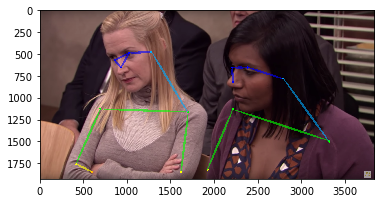

In [6]:
import cv2
make_pose_predictions_and_save_img('./test-images/office/1.png', model, R_368x368, test_tensor_tfms)

test-images/office/8.png


/Users/dhruv/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/Users/dhruv/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)


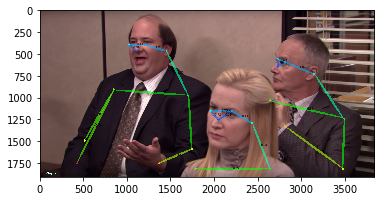

test-images/office/9.png


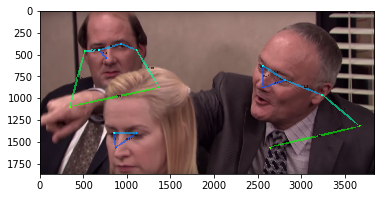

test-images/office/14.png


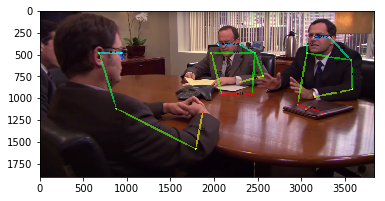

test-images/office/15.png


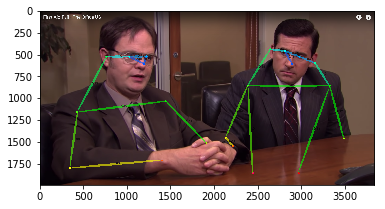

test-images/office/12.png


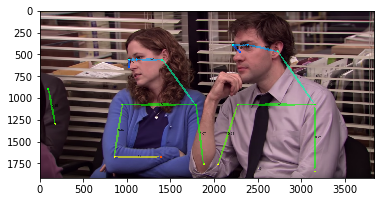

test-images/office/13.png


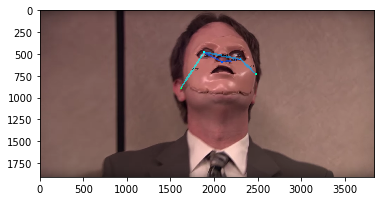

test-images/office/11.png


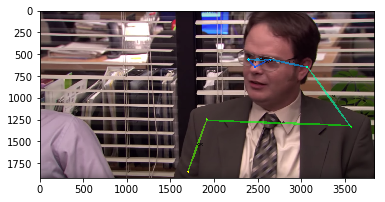

test-images/office/10.png


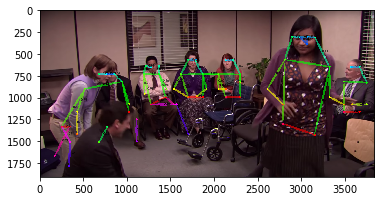

test-images/office/4.png


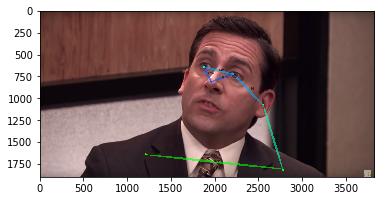

test-images/office/5.png


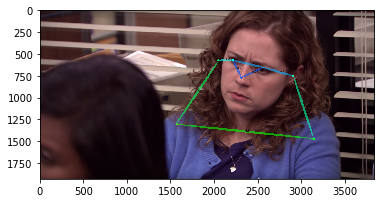

test-images/office/7.png


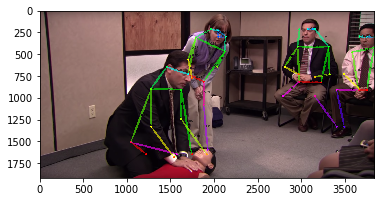

test-images/office/2.png


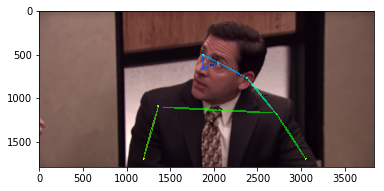

test-images/office/3.png


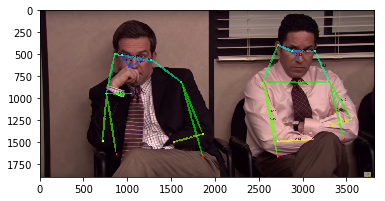

test-images/office/1.png


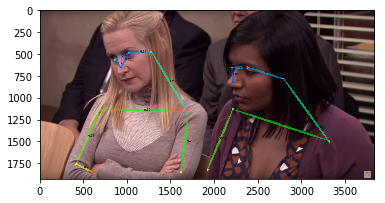

CPU times: user 1min 43s, sys: 4.87 s, total: 1min 48s
Wall time: 1min 11s


In [37]:
%%time

path = './test-images/office/'

for im_path in list(Path(path).iterdir()):
    im_path = str(im_path)
    print(im_path)
    if('.jpg'in im_path or '.png' in im_path):
        make_pose_predictions_and_save_img(im_path, model, R_368x368, test_tensor_tfms)

In [9]:
import cv2
cap = cv2.VideoCapture('./cpr-vid.mp4')
count = 0
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps =  cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, fps, (int(width), int(height)))

while cap.isOpened():
    ret,frame = cap.read()
    count = count + 1
    if(count>96):
        if(count>336):
            cap.release()
            cv2.destroyAllWindows()  # destroy all the opened windows
        else:
            pf, hm, un_im, pad = model_utils.get_average_pafs_and_hms_predictions_on_video_frame(frame, model, R_368x368, test_tensor_tfms)
            joint_pos_map = model_utils.get_joint_positions(hm.numpy(), nms_window=30)
            part_matches_map = model_utils.calculate_part_matches_from_predicted_joints_and_pafs(joint_pos_map, pf)

            canvas = model_utils.draw_bodypose(frame, part_matches_map, pad)
            out.write(canvas)

/Users/dhruv/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/Users/dhruv/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)
